**some notebook stuff**

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

**Libraries**

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import PIL
import time
import methods as mt
import datetime
import pandas as pd

**import molecule data**

In [3]:
# Create dictionaries of nodes/edges for all molecules
roots = mt.importMolecule('gxl')
nodesDict, edgesDict, edgesCountDict = mt.moleculeToList(roots)

**import validation and training data**

In [4]:
import pandas as pd
def read_file(file):
    df = pd.read_csv(file, sep=' ', header=None)
    lst = df.values.tolist()
    d = dict()
    for elt in lst:
        d[int(elt[0])] = {'class': elt[1], 'value': 1 if elt[1] == 'a' else 0}
    #lst: list of molecules [number, a/i]
    #  d: dict of molecules. key is number, value is {class: i/a, value: 1,0}
    return lst, d

validData, validDict = read_file('valid.txt')
trainData, trainDict = read_file('train.txt')

###### Gridsearch

In [5]:
def computeDistance(molecule1, molecule2, cn, ce):
    node1 = nodesDict[molecule1]
    node2 = nodesDict[molecule2]
    edges1 = edgesCountDict[molecule1]
    edges2 = edgesCountDict[molecule2]
    return mt.BP_fast(node1, node2, edges1, edges2, Cn=cn, Ce=ce)

def distMat(cn,ce):
    a = np.array([i[0] for i in validData])
    b = np.array([i[0] for i in trainData])
    fv = np.vectorize(computeDistance)
    start_time = time.time()
    distanceMatrix = fv(a[:, np.newaxis], b, cn, ce)
    print('Distance matrix found ({})'.format(datetime.timedelta(seconds=int(time.time() - start_time))))
    return distanceMatrix

In [29]:
import time
import pandas as pd

# choose cn and ce values for the grid search
Cn = pd.DataFrame({'cn':[0.01, 0.1, 0.5, 1, 5, 10], 'key':1})
Ce = pd.DataFrame({'ce':[0.01, 0.1, 0.5, 1, 5, 10], 'key':1})

# dataframe with the most important data
df = pd.merge(Cn,Ce,on='key')
df = df.drop(columns=['key'])
df['best_k'] = None
df['top_accuracy'] = None
df['time'] = np.inf

# dictionary with keys of type (cn,ce)
# stores all collected data inclusive distance matrix and accuracies for each k
dictionary = {}

outer_start = time.time()

for index, row in df.iterrows():
    cn = row.cn
    ce = row.ce
    print()
    print(color.BOLD + 'Hyperparameters: Cn = {}, Ce = {}'.format(cn,ce) + color.END)
    
    # find distance matrix for current hyperparameters Cn and Ce
    start = time.time()
    distanceMatrix = distMat(cn,ce)
    
    # determine accuracy for different k
    accuracy = 0
    k = 1
    accs = []
    k_vals = []
    validLength = len(validData)
    while k <= len(validData):
        for r in range(len(validData)):
            row = np.squeeze(np.asarray(distanceMatrix[r]))
            idx = np.argpartition(row, k)
            total = 0
            for i in range(k):
                total += trainDict[trainData[idx[i]][0]]['value']

            if total > k/2:
                if validDict[validData[r][0]]['class'] == 'a' :
                    accuracy += 1
            else:
                if validDict[validData[r][0]]['class'] == 'i' :
                    accuracy += 1
            
        accs.append(accuracy/validLength)
        k_vals.append(k)
        k += 2
        accuracy = 0
     
    # write to dataframe
    stop = time.time()
    max_acc = max(accs)
    best_k = k_vals[accs.index(max(accs))]
    df.loc[index,'time'] = stop-start
    df.loc[index,'best_k'] = best_k
    df.loc[index, 'top_accuracy'] = max_acc
    
    # write to dictionary
    dictionary[(cn,ce)] = {'cn': cn, 
                           'ce': ce, 
                           'k_vals': k_vals, 
                           'accs': accs, 
                           'disMat': distanceMatrix, 
                           'time': stop-start}

    
    print('Best accuracy: {} with k={}'.format(max_acc, best_k))
    print("Time taken: {}".format(datetime.timedelta(seconds=int(stop - start))))
    print('_________________________________________')

print()
print('Gridsearch took {}s'.format(datetime.timedelta(seconds=int(time.time() - outer_start))))
max_accuracy = df[['top_accuracy']].max()[0]
print(color.BOLD + 'Best achieved accuracy {}'.format(max_accuracy) + color.END)

# Save dataframe
datetime = time.strftime("%Y%m%d-%H%M%S")
df.to_pickle("./gridsearches/gridsearch_simple_" + datetime)
pd.DataFrame(dictionary).to_pickle("./gridsearches/gridsearch_dictionary_" + datetime)


Hyperparameters: Cn = 0.01, Ce = 0.01
Distance matrix found (0:00:13)
Best accuracy: 0.996 with k=3
Time taken: 0:00:16
_________________________________________

Hyperparameters: Cn = 0.01, Ce = 0.1
Distance matrix found (0:00:15)
Best accuracy: 0.996 with k=1
Time taken: 0:00:18
_________________________________________

Hyperparameters: Cn = 0.01, Ce = 0.5
Distance matrix found (0:00:13)
Best accuracy: 0.996 with k=1
Time taken: 0:00:16
_________________________________________

Hyperparameters: Cn = 0.01, Ce = 1.0
Distance matrix found (0:00:13)
Best accuracy: 0.996 with k=1
Time taken: 0:00:16
_________________________________________

Hyperparameters: Cn = 0.01, Ce = 5.0
Distance matrix found (0:00:13)
Best accuracy: 0.996 with k=1
Time taken: 0:00:16
_________________________________________

Hyperparameters: Cn = 0.01, Ce = 10.0
Distance matrix found (0:00:14)
Best accuracy: 0.996 with k=1
Time taken: 0:00:16
_________________________________________

Hyperparameters: Cn = 0.1

In [30]:
#pd.read_pickle("./gridsearches/gridsearch_simple_20200524-194059)
#pd.read_pickle("./gridsearches/gridsearch_dictionary_20200524-194059)
df

,cn,ce,best_k,top_accuracy,time
0,0.01,0.01,3,0.996,16.883893
1,0.01,0.10,1,0.996,18.022744
2,0.01,0.50,1,0.996,16.721250
3,0.01,1.00,1,0.996,16.599758
4,0.01,5.00,1,0.996,16.628928
5,0.01,10.00,1,0.996,16.918956
6,0.10,0.01,3,0.992,16.638783
7,0.10,0.10,1,0.996,16.501120
8,0.10,0.50,1,0.996,16.539928
9,0.10,1.00,1,0.996,16.930998


<Figure size 432x288 with 0 Axes>

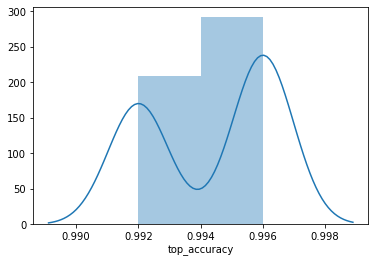

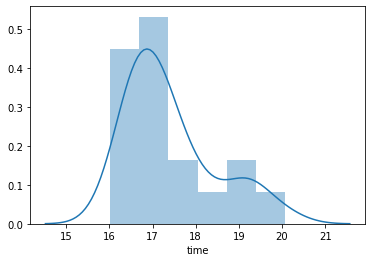

In [31]:
import seaborn as sns
sns.distplot(df['top_accuracy'])
plt.figure()
sns.distplot(df['time'])